#                                      Курсовой проект

### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)
Решение должно содержать

### Описание датасета

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error as mse, f1_score as f1

### Пути к директориям и файлам

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)

In [4]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [5]:
df_train.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [8]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00000,7500.00000,7500.00000,7500.00000,7500.00000,7500.00000,3419.00000,7486.00000,7500.00000,7500.00000,7500.00000,5943.00000,7500.00000
mean,1366391.72017,0.03013,11.13093,18.31747,945153.72747,0.17000,34.69260,0.11715,11873177.44507,289833.23520,18314.45413,1151.08750,0.28173
std,845339.19963,0.27160,4.90892,7.04195,16026216.67085,0.49860,21.68881,0.34719,31926122.97473,317871.38238,11926.76467,1604.45142,0.44987
min,164597.00000,0.00000,2.00000,4.00000,0.00000,0.00000,0.00000,0.00000,11242.00000,0.00000,0.00000,585.00000,0.00000
25%,844341.00000,0.00000,8.00000,13.50000,279229.50000,0.00000,16.00000,0.00000,180169.00000,114256.50000,10067.50000,711.00000,0.00000
50%,1168386.00000,0.00000,10.00000,17.00000,478159.00000,0.00000,32.00000,0.00000,309573.00000,209323.00000,16076.50000,731.00000,0.00000
75%,1640137.00000,0.00000,14.00000,21.80000,793501.50000,0.00000,50.00000,0.00000,519882.00000,360406.25000,23818.00000,743.00000,1.00000
max,10149344.00000,7.00000,43.00000,57.70000,1304726170.00000,7.00000,118.00000,4.00000,99999999.00000,6506797.00000,136679.00000,7510.00000,1.00000


- Maximum Open Credit обработать выбросы
- Current Loan Amount обработать выбросы
- Current Credit Balance - посмотреть выброс или нет.
- Credit score -  посмотреть частоту значений, возможно верхняя граница это просто ошибка лишей цифры.
- Current Credit Balance, Monthly Debt - посмотреть 0 значения.

### Выбросы

#### Maximum Open Credit

<AxesSubplot:xlabel='Maximum Open Credit'>

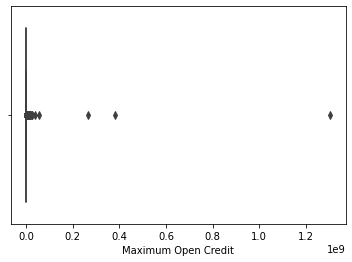

In [9]:
sns.boxplot(df_train['Maximum Open Credit'])

Значения совсем фантастические. Заменим все что выше q=0.975 медианой.

In [10]:
max_open_credit = np.quantile(df_train['Maximum Open Credit'], q=0.975)
max_open_credit_median = df_train['Maximum Open Credit'].median()
df_train.loc[df_train['Maximum Open Credit'] > max_open_credit, 'Maximum Open Credit'] = max_open_credit_median

<AxesSubplot:xlabel='Maximum Open Credit', ylabel='Density'>

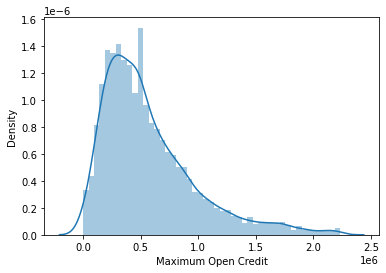

In [11]:
sns.distplot(df_train['Maximum Open Credit'])

In [12]:
df_train['Maximum Open Credit'].describe()

count      7500.00000
mean     570542.45013
std      407320.84502
min           0.00000
25%      279229.50000
50%      478153.50000
75%      750233.00000
max     2234056.00000
Name: Maximum Open Credit, dtype: float64

#### Current Loan Amount

In [13]:
df_train['Current Loan Amount'].value_counts()

99999999.00000    870
218064.00000        6
89298.00000         6
216106.00000        5
265826.00000        5
                 ... 
104324.00000        1
201080.00000        1
427812.00000        1
665544.00000        1
191136.00000        1
Name: Current Loan Amount, Length: 5386, dtype: int64

<AxesSubplot:>

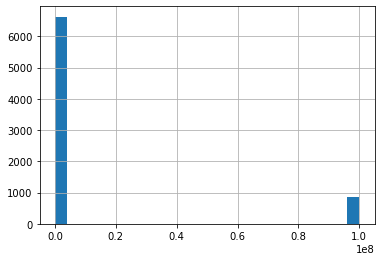

In [14]:
df_train['Current Loan Amount'].hist(bins=25)

Я так подозреваю значение 99999999 это правое скопление, явно не являющееся нормальным. Заменим медианным значением, и создадим доп признак показывающий, что был выброс, т.к. выбросов очень много.

In [15]:
current_loan_amount_median = df_train['Current Loan Amount'].median()

df_train["Current Loan Amount outlier"] = 0
df_train.loc[df_train['Current Loan Amount'] == 99999999, 'Current Loan Amount outlier'] = 1
df_train.loc[df_train['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = current_loan_amount_median

<AxesSubplot:xlabel='Current Loan Amount', ylabel='Density'>

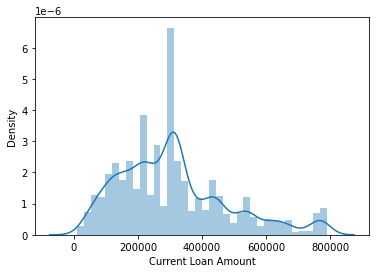

In [16]:
sns.distplot(df_train['Current Loan Amount'])

In [17]:
df_train['Current Loan Amount'].describe()

count     7500.00000
mean    309088.02907
std     171393.74013
min      11242.00000
25%     180169.00000
50%     309567.50000
75%     396929.50000
max     789030.00000
Name: Current Loan Amount, dtype: float64

#### Current Credit Balance

Верхняя граница достаточно большая, но и не чтоб супербольшая. Хотя не известно, включается ли тут деньги лежащие на дебетовом счете в общую сумму. Можно посмотреть, например сколько счетов у людей, у которых кредитный счет больше 0.975 перцентиля, или же можем посмотреть людей у которых кредитный счет выше чем сумма кредита. 

<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

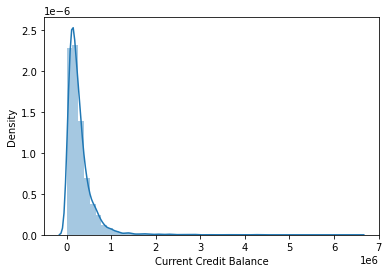

In [18]:
sns.distplot(df_train['Current Credit Balance'])

In [19]:
high_credit_balance = np.quantile(df_train['Current Credit Balance'], q=0.975)
credit_balance_median = df_train['Current Credit Balance'].median()

df_train["Current Credit Balance outlier"] = 0
df_train.loc[df_train['Current Credit Balance'] > high_credit_balance, 'Current Credit Balance outlier'] = 1
df_train.loc[df_train['Current Credit Balance'] > high_credit_balance, 'Current Credit Balance'] = credit_balance_median

<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

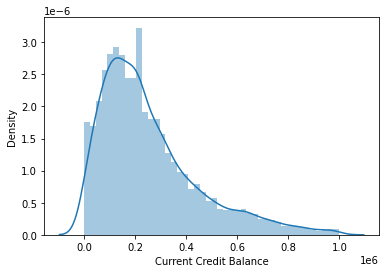

In [20]:
sns.distplot(df_train['Current Credit Balance'])

#### Monthly Debt

Теперь нужно посмотреть нули.

<AxesSubplot:xlabel='Monthly Debt', ylabel='Density'>

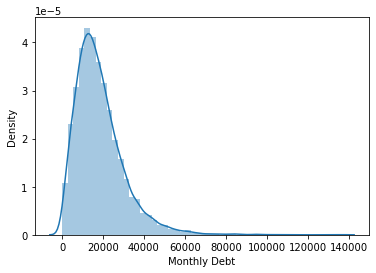

In [21]:
sns.distplot(df_train['Monthly Debt'])

In [22]:
df_train.loc[df_train['Monthly Debt'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Loan Amount outlier,Current Credit Balance outlier
780,Home Mortgage,867749.00000,10+ years,0.00000,2.00000,16.50000,0.00000,0.00000,66.00000,0.00000,home improvements,Short Term,75350.00000,0.00000,0.00000,704.00000,0,0,0
1643,Rent,NaN,9 years,0.00000,3.00000,10.00000,0.00000,0.00000,NaN,0.00000,other,Short Term,332156.00000,0.00000,0.00000,NaN,1,0,0
3219,Home Mortgage,NaN,10+ years,0.00000,3.00000,18.50000,0.00000,0.00000,NaN,0.00000,debt consolidation,Short Term,79200.00000,0.00000,0.00000,NaN,0,0,0
3496,Rent,233567.00000,1 year,0.00000,7.00000,11.70000,0.00000,0.00000,0.00000,NaN,educational expenses,Short Term,210166.00000,0.00000,0.00000,746.00000,0,0,0
4165,Rent,1254513.00000,10+ years,0.00000,6.00000,23.40000,0.00000,0.00000,60.00000,0.00000,take a trip,Short Term,309573.00000,0.00000,0.00000,748.00000,0,1,0
7124,Rent,NaN,1 year,0.00000,4.00000,11.00000,0.00000,0.00000,50.00000,0.00000,debt consolidation,Short Term,134024.00000,0.00000,0.00000,NaN,0,0,0


In [23]:
df_train['Monthly Debt'].median()

16076.5

Вообще ерунда, кредитная история много лет, максимальный кредит 0, при этом просрочка кредита у некторых имеется. В тоже время имеется взятый кредит, но выплата 0 в месяц. Мусорные наблюдения, которые стоит выкинуть.  Я посмотрел в тестовом дата сете, таких там нет, по этому тут просто выкинем. Если бы у нас был признак точного срока кредита, можно былобы расчитать, но мы имеем только (короткий\длинный).

In [24]:
df_train = df_train.loc[df_train['Monthly Debt'] != 0]

Вообще нижняя планка меня удивляет, куча наблюдений, в которых короткое время кредита, при этом ежемесячный платеж  0.1% - 0.5%  от суммы. С другой стороны, конечно, если мне, грубо говоря, надо отдавать 100руб в месяц за кредит, то вероятность, что я отдам очень высока.

В общем делаем так, те что ниже нижней границы и при этом срок выплаты более 10 лет, мы считаем выбросами и подгоняем под значение, когда мы бы выплачивали весь кредит в течении  17 месяцев. (это среднее время выплаты всех кредитов)

In [25]:
min_monthly_debt = np.quantile(df_train['Monthly Debt'], q=0.025)
mean_monthly_debt_months = df_train['Current Loan Amount'].mean() / df_train['Monthly Debt'].mean()

df_train.loc[(df_train['Monthly Debt'] < min_monthly_debt) & ((df_train['Current Loan Amount'] / df_train['Monthly Debt']) > 120), 'Monthly Debt'] = df_train['Current Loan Amount'] / mean_monthly_debt_months

#### Credit Score

<AxesSubplot:>

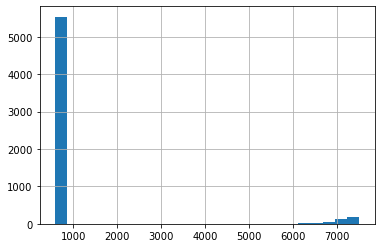

In [26]:
df_train["Credit Score"].hist(bins=25)

In [27]:
df_train["Credit Score"].value_counts()

740.00000     169
747.00000     168
748.00000     156
745.00000     152
742.00000     151
             ... 
629.00000       1
606.00000       1
6830.00000      1
6670.00000      1
620.00000       1
Name: Credit Score, Length: 268, dtype: int64

Да, сделаем обрезание крайней цифры. =)

In [28]:
df_train.loc[df_train['Credit Score'] > 2000, 'Credit Score'] //= 10

### Пропуски

#### Annual Income 

Подумаем, чем можно заполнить пропуски. Значений довольно много, просто какойто средней или медианой заполнять получится перекос. Либо делаем так и создаем признак, и отмечаем, что было пропущено значение, либо выбрать метод заполнения по хитрее. 

<AxesSubplot:xlabel='Annual Income', ylabel='Density'>

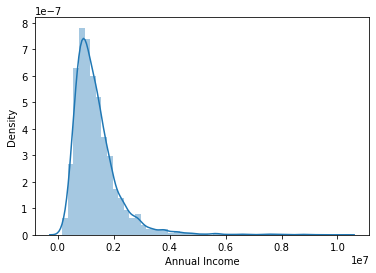

In [29]:
sns.distplot(df_train["Annual Income"])

Можно посмотреть, как разделяется среднее по стажу работы.

In [30]:
df_train.groupby(by="Years in current job")["Annual Income"].mean()

Years in current job
1 year      1271418.78841
10+ years   1511082.12439
2 years     1324516.68157
3 years     1396487.28163
4 years     1371733.44865
5 years     1330785.57323
6 years     1311730.11966
7 years     1341805.04545
8 years     1390800.27143
9 years     1444429.35979
< 1 year    1204723.05369
Name: Annual Income, dtype: float64

Не особо сильно, но явно виден рост зп со стажем, что стоило ожидать.
В теории, ежемесячный платеж должен быть завязан на ЗП, можно посмотреть по матрице корреляции данный признак.

In [31]:
corr_matrix = df_train.corr()
corr_matrix["Annual Income"]

Annual Income                     1.00000
Tax Liens                         0.06622
Number of Open Accounts           0.18824
Years of Credit History           0.18637
Maximum Open Credit               0.29853
Number of Credit Problems        -0.01553
Months since last delinquent     -0.10232
Bankruptcies                     -0.06692
Current Loan Amount               0.41775
Current Credit Balance            0.30812
Monthly Debt                      0.58951
Credit Score                      0.02876
Credit Default                   -0.10161
Current Loan Amount outlier       0.03002
Current Credit Balance outlier    0.23631
Name: Annual Income, dtype: float64

Я был прав, самая большая корреляция с Ежемесячным платежом. Можно например узнать соотношение средней ЗП по всем к средней Ежемесячных платежей, далее предсказывать пропущенные ЗП домножая на коэффициент. Ну и всеже стоит их пометить.

In [32]:
annual_incom_coef = df_train["Annual Income"].mean() / df_train['Monthly Debt'].mean()

In [33]:
df_train["Annual Income NAN"] = 0
df_train.loc[df_train["Annual Income"].isnull(), "Annual Income NAN"] = 1

In [34]:
df_train.loc[df_train["Annual Income"].isnull(), "Annual Income"] = df_train["Monthly Debt"] * annual_incom_coef

In [35]:
df_train.loc[df_train["Annual Income NAN"] == 1, "Annual Income"].describe()

count      1554.00000
mean    1375401.60450
std      882701.29697
min       55624.45356
25%      765795.27882
50%     1197806.95001
75%     1762756.63887
max     7095216.27388
Name: Annual Income, dtype: float64

<AxesSubplot:xlabel='Annual Income', ylabel='Density'>

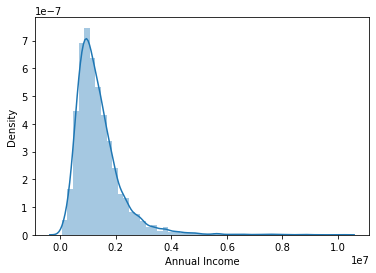

In [36]:
sns.distplot(df_train["Annual Income"])

Почти не отличается от средней по этому признаку, однако распределение значений более честное, на мой взгляд.

#### Years in current job

Ну тут значений не много, заменим модой

In [37]:
current_job_mode = df_train['Years in current job'].mode()[0]

In [38]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = current_job_mode

#### Months since last delinquent

Признак не простой, вероятнее всего пропущенные значения, это клиенты которые никогда не просрачивали кредит, и важно это правильно объяснить модели т.к. это весомый довод выдать кредит. Мы не можем написать 0, т.к. это значит, что просрока была в это м месяце. Нужно большое число. Можно взять максимальное число из признака и также создать доп признак.

In [39]:
df_train.loc[df_train['Months since last delinquent'].isnull()]['Credit Default'].value_counts()

0    2950
1    1129
Name: Credit Default, dtype: int64

Хотя даже такие ребята, которые не имели просрочки, имеют соотношение целевого признака 1к3. Но делать нечего, надо както заполнять.

<AxesSubplot:>

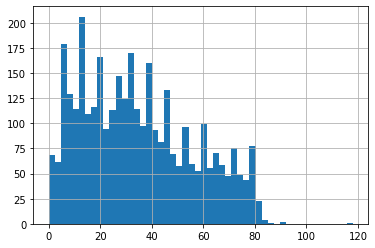

In [40]:
df_train['Months since last delinquent'].hist(bins=50)

In [41]:
df_train['Delinquent'] = 1
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Delinquent'] = 0

max_delinquent = df_train['Months since last delinquent'].max()

df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = max_delinquent
#df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_train['Years of Credit History'] * 12

<AxesSubplot:>

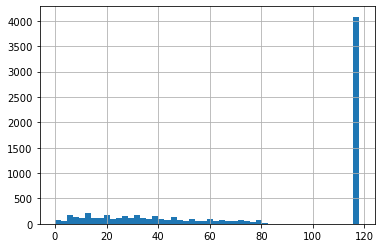

In [42]:
df_train['Months since last delinquent'].hist(bins=50)

Рисковая практика, получился целый доп кластер. Попробуем пока оставить. С одной стороны информация то полезная, когда был послений прокол.. И доп признак, Были просрочки \ Не было. 


#### Bankruptcies

Тут пропусков не много, можно заменить медианой.

In [43]:
bankruptcies_median = df_train['Bankruptcies'].median()

In [44]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = bankruptcies_median

#### Credit Score

In [45]:
corr_matrix = df_train.corr()
corr_matrix["Credit Score"]

Annual Income                     0.02876
Tax Liens                        -0.01646
Number of Open Accounts          -0.03465
Years of Credit History           0.06838
Maximum Open Credit               0.11219
Number of Credit Problems        -0.05502
Months since last delinquent      0.08339
Bankruptcies                     -0.04135
Current Loan Amount              -0.20503
Current Credit Balance           -0.02123
Monthly Debt                     -0.07009
Credit Score                      1.00000
Credit Default                   -0.20707
Current Loan Amount outlier       0.14991
Current Credit Balance outlier    0.01567
Annual Income NAN                     NaN
Delinquent                       -0.09238
Name: Credit Score, dtype: float64

Для более точного предсказания хорошо бы знать формулу расчета рейтинга, т.к. корреляции слабые, для нормальних предсказаний, заполним медианой и пометим.

In [46]:
credit_score_median = df_train['Credit Score'].median()

In [47]:
df_train['Credit Score NAN'] = 0
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score NAN'] = 1
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = credit_score_median

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7494 entries, 0 to 7499
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home Ownership                  7494 non-null   object 
 1   Annual Income                   7494 non-null   float64
 2   Years in current job            7494 non-null   object 
 3   Tax Liens                       7494 non-null   float64
 4   Number of Open Accounts         7494 non-null   float64
 5   Years of Credit History         7494 non-null   float64
 6   Maximum Open Credit             7494 non-null   float64
 7   Number of Credit Problems       7494 non-null   float64
 8   Months since last delinquent    7494 non-null   float64
 9   Bankruptcies                    7494 non-null   float64
 10  Purpose                         7494 non-null   object 
 11  Term                            7494 non-null   object 
 12  Current Loan Amount             74

In [49]:
def analyse_numeric_mean_stat(df, target, alpha=0.05):
    # df - датасет
    # target - целевая переменная
    # alpha - уровень значимости
    # для бинарного таргета
    
    confirmed = {}
    rejected = {}
    df = df.select_dtypes(include='number')
    colslist = df.columns.to_list()
    colslist.remove(target)
    
    for i in colslist:
        print(f'Проверяем признак {i}')
        print('Нулевая гипотеза: средние значения в выборках по классам целевой переменной равны')
        print('Альтернативная гипотеза: средние значения в выборках по классам целевой переменной различаются')
        print(f'Распределение признака {i} по классам')
        spread = df[[i, target]]
        spread_1 = spread.loc[spread[target] == 1, i]
        spread_0 = spread.loc[spread[target] == 0, i]
        sns.kdeplot(spread_0, shade=True, label = 'Target 0', color='g')
        sns.kdeplot(spread_1, shade=True, label = 'Target 1', color='r')
        plt.xlabel(i)
        plt.title(f'{i} grouped by target variable')
        plt.show()
        print('Проверка на нормальность: ')
        shap = shapiro(spread[i])
        if shap[1] < alpha:
            print(f'По полученному значению p-value, которое меньше {alpha}, можем заключить, что гипотеза о "нормальности" отвергается.')
            print(f'Мы не можем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака {i}, воспользуемся непараметрическим аналогом, критерием Манна-Уитни')
            man = mannwhitneyu(spread_1, spread_0)
            if man[1] < alpha:
                print(f'Согласно значению p-value = {man[1]}, гипотеза о равности мат. ожиданий ОТВЕРГАЕТСЯ, но стоит ради дополнительной проверки обратиться к доверительным интервалам')
                plt.figure(figsize=(8, 5))

                sns.pointplot(x=target, y=i, data=spread, capsize=.1)

                plt.title(f'Confidence intervals (95 %) for {i}')
                plt.show()
                rejected[i] = man[1]
            else:
                print(f'Согласно значению p-value = {man[1]}, гипотеза о равности мат. ожиданий ПОДТВЕРЖДАЕТСЯ, но стоит ради дополнительной проверки обратиться к доверительным интервалам')
                plt.figure(figsize=(8, 5))

                sns.pointplot(x=target, y=i, data=spread, capsize=.1)

                plt.title(f'Confidence intervals (95 %) for {i}')
                plt.show()
                confirmed[i] = man[1]
        else:
            print(f'p-value, больше {alpha}, похоже, что гипотеза о "нормальности" подтверждается.')
            print(f'Мы можем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака {i}')
            t = ttest_ind(spread_1, spread_0)
            if t[1] < alpha:
                print(f'Согласно значению p-value = {t[1]}, гипотеза о равности мат. ожиданий ОТВЕРГАЕТСЯ, но стоит ради дополнительной проверки обратиться к доверительным интервалам')
                plt.figure(figsize=(8, 5))

                sns.pointplot(x=target, y=i, data=spread, capsize=.1)

                plt.title(f'Confidence intervals (95 %) for {i}')
                plt.show()
                rejected[i] = t[1]
            else:
                print(f'Согласно значению p-value = {t[1]}, гипотеза о равности мат. ожиданий ПОДТВЕРЖДАЕТСЯ, но стоит ради дополнительной проверки обратиться к доверительным интервалам')
                plt.figure(figsize=(8, 5))

                sns.pointplot(x=target, y=i, data=spread, capsize=.1)

                plt.title(f'Confidence intervals (95 %) for {i}')
                plt.show()
                confirmed[i] = t[1]
    print('ЗАКЛЮЧЕНИЕ')
    print('Мы подтвердили, что в этих признаках разницы в мат ожиданиях нет.')
    for i in confirmed:
        print(f'{i} : {confirmed[i]}')
    print('*'*50)
    print('Мы опровергли, что в этих признаках разницы в мат ожиданиях нет. Стоит обратить на них пристальное внимание')
    for i in rejected:
        print(f'{i} : {rejected[i]}')
    

In [50]:
df_train.loc[df_train['Number of Credit Problems'].isin([6,7]), 'Number of Credit Problems'] = 0
df_train.loc[df_train['Number of Credit Problems'] == 5 , 'Number of Credit Problems'] = 4
df_train.loc[df_train['Number of Credit Problems'] == 3 , 'Number of Credit Problems'] = 2
df_train.loc[df_train['Number of Credit Problems'] == 1 , 'Number of Credit Problems'] = 0

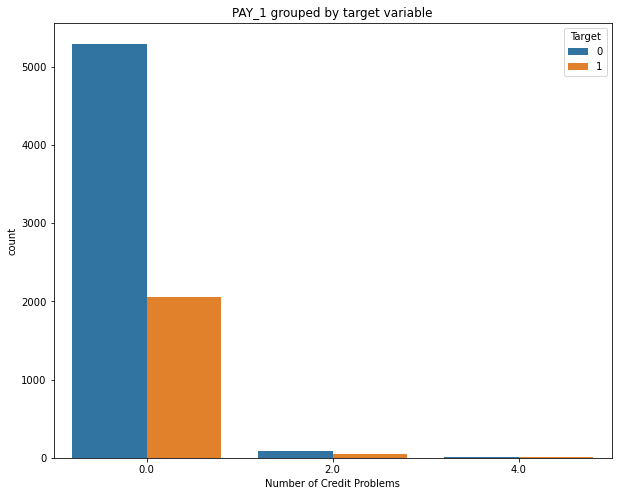

In [51]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Number of Credit Problems", hue='Credit Default', data=df_train)
plt.title('PAY_1 grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [52]:
pay1_and_target_s = df_train.loc[df_train['Number of Credit Problems'].isin([2,4]), ['Bankruptcies', 'Number of Credit Problems', 'Credit Default']]

In [53]:
table = pay1_and_target_s.pivot_table(values='Bankruptcies', index='Number of Credit Problems', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Number of Credit Problems,,
2.00000,81,47
4.00000,6,10


In [54]:
df_train['Number of Credit Problems'].value_counts()

0.00000    7350
2.00000     128
4.00000      16
Name: Number of Credit Problems, dtype: int64

In [55]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.046793083022117106

<AxesSubplot:xlabel='Annual Income', ylabel='Density'>

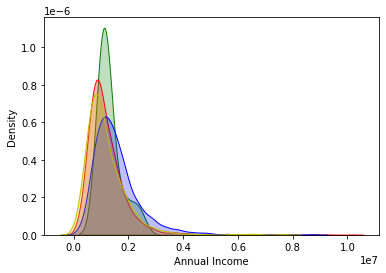

In [56]:
incom_spread = df_train[['Home Ownership', 'Annual Income']]
incom_have_mortgage = incom_spread.loc[incom_spread['Home Ownership'] == 'Have Mortgage', 'Annual Income']
incom_rent = incom_spread.loc[incom_spread['Home Ownership'] == 'Rent', 'Annual Income']
incom_home_mortgage = incom_spread.loc[incom_spread['Home Ownership'] == 'Home Mortgage', 'Annual Income']
incom_own_home = incom_spread.loc[incom_spread['Home Ownership'] == 'Own Home', 'Annual Income']
sns.kdeplot(incom_have_mortgage,  shade=True,  color='g')
sns.kdeplot(incom_rent,  shade=True,  color='r')
sns.kdeplot(incom_home_mortgage,  shade=True,  color='b')
sns.kdeplot(incom_own_home,   shade=True, color='y')

In [57]:
df_train.groupby(by='Home Ownership')['Annual Income'].mean()

Home Ownership
Have Mortgage   1302719.04224
Home Mortgage   1562367.52608
Own Home        1187721.18750
Rent            1185059.39477
Name: Annual Income, dtype: float64

### Обработка не числовых значений.

#### Home Ownership

In [58]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3635
Rent             3200
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [59]:
df_train.groupby(by='Home Ownership')['Credit Default'].mean()

Home Ownership
Have Mortgage   0.16667
Home Mortgage   0.25199
Own Home        0.29675
Rent            0.31312
Name: Credit Default, dtype: float64

Чем больше среднее, тем больше наблюдений 1 класса. Интересно, что у тех, кто арендует дома\квартиру, не погашен кредит чаще всего. Можно заменить тип домовладения, соответствующей статистикой.

In [480]:
home_ownership_credit_default_stat = df_train.groupby(by='Home Ownership')['Credit Default'].mean().to_dict()

In [481]:
home_ownership_credit_default_stat

{0.027777777777777776: 0.16666666666666666,
 0.06350122699038276: 0.2519944979367263,
 0.08806308512239344: 0.29675425038639874,
 0.09804726562499999: 0.313125}

In [482]:
df_train.replace({"Home Ownership": home_ownership_credit_default_stat}, inplace=True )

#### Years in current job

In [63]:
df_train['Years in current job'].value_counts()

10+ years    2700
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        502
4 years       469
6 years       426
7 years       396
8 years       339
9 years       258
Name: Years in current job, dtype: int64

Тут можно просто, перевести в непрерывный тип, т.к. по сути признак таким и является. 

In [64]:
years_in_current_job_dict = {'10+ years': 10, '2 years': 2, '3 years': 3, '< 1 year': 0, '5 years': 5, '1 year': 1, '4 years': 4, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9}

In [65]:
df_train.replace({'Years in current job': years_in_current_job_dict}, inplace=True)

#### Purpose

In [66]:
df_train['Purpose'].value_counts()

debt consolidation      5942
other                    664
home improvements        411
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               36
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses       9
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Много значений. Надо прикинуть, как их можно описать другими признаками. Например цель кредита всегда влияет на размер кредита. Можно прикинуть средний размер кредита, который берут на эту цель и записать в значения.

In [67]:
purpose_stat = df_train.groupby(by='Purpose')['Current Loan Amount'].mean().to_dict()

In [68]:
df_train.replace({'Purpose': purpose_stat}, inplace=True)

In [485]:
df_train.groupby(by='Purpose')['Current Loan Amount'].mean()

Purpose
118690.00000   1.00000
140234.87500   0.25000
142085.77778   0.27778
172571.00000   0.18182
186957.94792   0.25000
214305.66667   0.11111
223605.21127   0.30986
233515.91867   0.29518
253267.66667   0.26667
257253.97500   0.22500
282836.65385   0.53846
316658.20438   0.26277
321389.28071   0.27836
325001.79412   0.26471
352753.88372   0.42636
Name: Credit Default, dtype: float64

####  Term

In [69]:
df_train['Term'].value_counts()

Short Term    5550
Long Term     1944
Name: Term, dtype: int64

Просто переведем в бинарный признак.

In [70]:
df_train['Term'] = (df_train['Term'] == 'Short Term').astype(int)

In [71]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7494 entries, 0 to 7499
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home Ownership                  7494 non-null   float64
 1   Annual Income                   7494 non-null   float64
 2   Years in current job            7494 non-null   int64  
 3   Tax Liens                       7494 non-null   float64
 4   Number of Open Accounts         7494 non-null   float64
 5   Years of Credit History         7494 non-null   float64
 6   Maximum Open Credit             7494 non-null   float64
 7   Number of Credit Problems       7494 non-null   float64
 8   Months since last delinquent    7494 non-null   float64
 9   Bankruptcies                    7494 non-null   float64
 10  Purpose                         7494 non-null   float64
 11  Term                            7494 non-null   int32  
 12  Current Loan Amount             74

Надо прикинуть, какие факторы из известных признаков могут спровоцировать не уплату кредита.
1) Самое вероятное, это малая ЗП.

Скорее показательно будет то, меньше ли доход  чем месячный платежа умноженного на коэффициент соотношения средней зп к среднему платежу.


<AxesSubplot:xlabel='Monthly Debt', ylabel='Density'>

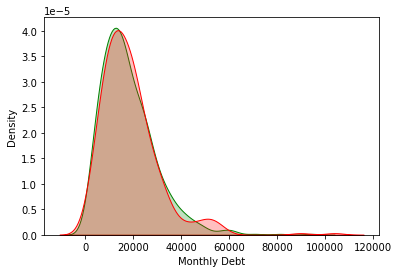

In [74]:
incom_spread = df_train[['Monthly Debt', 'Credit Default']].sample(1000)
incom_1 = incom_spread.loc[incom_spread['Credit Default'] == 1, 'Monthly Debt']
incom_0 = incom_spread.loc[incom_spread['Credit Default'] == 0, 'Monthly Debt']
sns.kdeplot(incom_0, shade=True,  color='g')
sns.kdeplot(incom_1, shade=True,  color='r')

In [75]:
shapiro(incom_spread['Monthly Debt'])


ShapiroResult(statistic=0.8735789060592651, pvalue=1.07135428723729e-27)

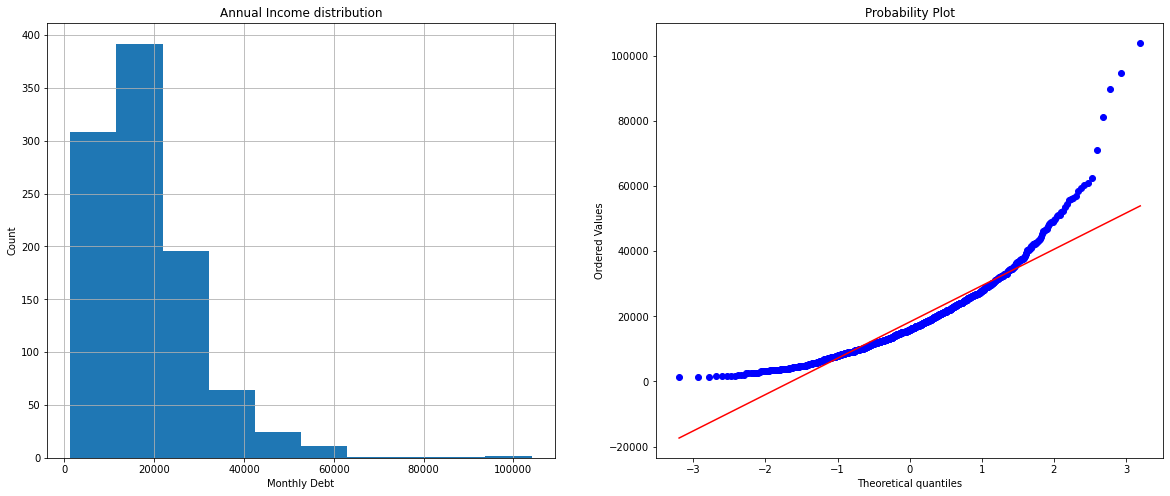

In [76]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Monthly Debt')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
incom_spread['Monthly Debt'].hist()

plt.subplot(122)
probplot(incom_spread['Monthly Debt'], dist='norm', plot=plt)
plt.show()

In [77]:
mannwhitneyu(incom_0, incom_1)

MannwhitneyuResult(statistic=103206.5, pvalue=0.31717645875969613)

<AxesSubplot:xlabel='Credit Default', ylabel='Monthly Debt'>

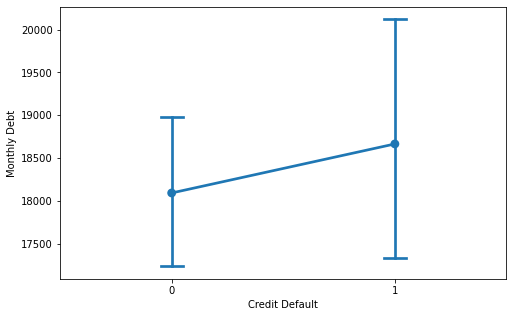

In [78]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Credit Default', y='Monthly Debt', data=incom_spread, capsize=.1)


Выходит разница есть. Причем средняя ЗП тех людей, которые вернули кредит выше.

In [79]:
low_income = df_train.loc[df_train['Annual Income'] < (df_train['Monthly Debt']* annual_incom_coef), 'Credit Default']
norm_income = df_train.loc[df_train['Annual Income'] >= (df_train['Monthly Debt']* annual_incom_coef), 'Credit Default']

In [80]:
low_income.value_counts(normalize=True)

0   0.69036
1   0.30964
Name: Credit Default, dtype: float64

In [81]:
norm_income.value_counts(normalize=True)

0   0.73851
1   0.26149
Name: Credit Default, dtype: float64

Ну в целом смещение видно, но не большое. Однако стоит учесть, что мы часть пропущенных значений также заполняли и они идут в копилку norm_incom. Сделаем доп признак, и в будущем посмотрем на его влияние в модели.

In [82]:
df_train['Money_after_debt'] = df_train['Annual Income'] / 12 - df_train['Monthly Debt']

2) Возможно состояние кредитного счета. К примеру если на счету денег меньше чем ежемесячный платеж.


In [83]:
df_train['Money_after_debt'].describe()

count     7494.00000
mean     95515.38110
std      63678.18459
min       3881.37113
25%      56217.93750
50%      81008.90922
75%     116673.94633
max     784543.66667
Name: Money_after_debt, dtype: float64

In [84]:
df_train['Annual Income'].describe()

count       7494.00000
mean     1368492.69514
std       853215.55373
min        55624.45356
25%       833990.75000
50%      1173915.00000
75%      1674574.50000
max     10149344.00000
Name: Annual Income, dtype: float64

In [85]:
df_train.corr()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Loan Amount outlier,Current Credit Balance outlier,Annual Income NAN,Delinquent,Credit Score NAN,Money_after_debt
Home Ownership,1.00000,-0.21575,-0.20428,0.01583,-0.12469,-0.19793,-0.18183,0.00751,0.05252,0.00677,...,-0.18100,-0.20803,-0.03179,0.06629,-0.01333,-0.08671,0.00797,-0.03873,0.00797,-0.20230
Annual Income,-0.21575,1.00000,0.08142,0.06306,0.22700,0.19070,0.31618,0.01935,-0.07982,-0.07306,...,0.33145,0.67863,0.02570,-0.07096,0.02525,0.26226,0.00414,0.06350,0.00414,0.99067
Years in current job,-0.20428,0.08142,1.00000,0.02511,0.04270,0.25049,0.11006,0.00823,-0.04866,0.07498,...,0.12557,0.09778,-0.02071,0.00665,-0.00327,0.03195,-0.00378,0.05195,-0.00378,0.07277
Tax Liens,0.01583,0.06306,0.02511,1.00000,-0.00549,0.00907,-0.01797,0.52068,-0.03472,0.05740,...,-0.01770,0.02846,-0.01348,0.02435,-0.00799,0.00418,0.00622,0.05327,0.00622,0.06513
Number of Open Accounts,-0.12469,0.22700,0.04270,-0.00549,1.00000,0.14446,0.41182,-0.01523,-0.06656,-0.01926,...,0.31235,0.39997,-0.03004,0.02870,0.00029,0.11571,0.00314,0.06323,0.00314,0.17926
Years of Credit History,-0.19793,0.19070,0.25049,0.00907,0.14446,1.00000,0.25079,0.02689,-0.13219,0.08550,...,0.22089,0.19244,0.06054,-0.02045,0.00944,0.12061,0.00194,0.13646,0.00194,0.17723
Maximum Open Credit,-0.18183,0.31618,0.11006,-0.01797,0.41182,0.25079,1.00000,-0.06443,0.09960,-0.16226,...,0.64746,0.37984,0.09891,-0.05233,0.02749,0.17738,-0.00129,-0.11626,-0.00129,0.28257
Number of Credit Problems,0.00751,0.01935,0.00823,0.52068,-0.01523,0.02689,-0.06443,1.00000,-0.02518,0.31823,...,-0.05871,-0.01190,-0.03802,0.04096,-0.01984,-0.01083,0.00170,0.04744,0.00170,0.02382
Months since last delinquent,0.05252,-0.07982,-0.04866,-0.03472,-0.06656,-0.13219,0.09960,-0.02518,1.00000,0.04177,...,0.10187,-0.03646,0.07579,-0.01089,0.02045,0.04227,0.01569,-0.94307,0.01569,-0.08236
Bankruptcies,0.00677,-0.07306,0.07498,0.05740,-0.01926,0.08550,-0.16226,0.31823,0.04177,1.00000,...,-0.17379,-0.08243,-0.03761,0.00157,-0.00564,-0.05164,-0.00461,-0.00513,-0.00461,-0.06628


Заново загрузим трейн дата сет, разобьем на трейн и валид, и еще раз проделаем все наши манипуляции.

In [575]:
train = pd.read_csv(TRAIN_DATASET_PATH)

In [576]:
valid = train.iloc[5000:]
train = train.iloc[:5000]



Заново переопределим переменные

#### Переменные

In [577]:
max_open_credit = np.quantile(train['Maximum Open Credit'], q=0.975)
max_open_credit_median = train['Maximum Open Credit'].median()
current_loan_amount_median = train['Current Loan Amount'].median()
high_credit_balance = np.quantile(train['Current Credit Balance'], q=0.975)
credit_balance_median = train['Current Credit Balance'].median()
min_monthly_debt = np.quantile(train['Monthly Debt'], q=0.025)
mean_monthly_debt_months = train['Current Loan Amount'].mean() / train['Monthly Debt'].mean()
annual_incom_coef = train["Annual Income"].mean() / train['Monthly Debt'].mean()
current_job_mode = train['Years in current job'].mode()[0]
bankruptcies_median = train['Bankruptcies'].median()
credit_score_median = train['Credit Score'].median()
home_ownership_credit_default_stat = train.groupby(by='Home Ownership')['Credit Default'].mean().to_dict()
years_in_current_job_dict = {'10+ years': 10, '2 years': 2, '3 years': 3, '< 1 year': 0, '5 years': 5, '1 year': 1, '4 years': 4, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9}
purpose_stat = train.groupby(by='Purpose')['Current Loan Amount'].mean().to_dict()
max_delinquent = train['Months since last delinquent'].max()


#### Функция предобработки данных

In [578]:
def prep_data(df):
    
    #Выбросы
    
    #df.loc[df['Maximum Open Credit'] > max_open_credit, 'Maximum Open Credit'] = max_open_credit_median
    

    df["Current Loan Amount outlier"] = 0
    df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount outlier'] = 1
    #df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = current_loan_amount_median
    #df = df.loc[df['Current Loan Amount'] != 99999999]
    
    
    #df["Current Credit Balance outlier"] = 0
    #df.loc[df['Current Credit Balance'] > high_credit_balance, 'Current Credit Balance outlier'] = 1
    #df.loc[df['Current Credit Balance'] > high_credit_balance, 'Current Credit Balance'] = credit_balance_median
    
    
    #df = df.loc[df['Monthly Debt'] != 0]
    #df.loc[(df['Monthly Debt'] < min_monthly_debt) & ((df['Current Loan Amount'] / df['Monthly Debt']) > 120), 'Monthly Debt'] = df['Current Loan Amount'] / mean_monthly_debt_months
    
    #df.loc[df['Credit Score'] > 2000, 'Credit Score'] //= 10
    
    #Пропуски
    
    #df["Annual Income NAN"] = 0
    #df.loc[df["Annual Income"].isnull(), "Annual Income NAN"] = 1
    df.loc[df["Annual Income"].isnull(), "Annual Income"] = df["Monthly Debt"] * annual_incom_coef
    
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = current_job_mode
    
    df['Delinquent'] = 1
    df.loc[df['Months since last delinquent'].isnull(), 'Delinquent'] = 0
    
    #df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df['Years of Credit History'] * 12
    df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = max_delinquent
    
    
    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = bankruptcies_median
    
    #df['Credit Score NAN'] = 0
    #df.loc[df['Credit Score'].isnull(), 'Credit Score NAN'] = 1
    df.loc[df['Credit Score'].isnull(), 'Credit Score'] = credit_score_median
    

    #Фичи
    
    #df = df.drop('Months since last delinquent', 1)
    
    df.replace({"Home Ownership": home_ownership_credit_default_stat}, inplace=True )
        
    df.replace({'Years in current job': years_in_current_job_dict}, inplace=True)
    
    df.replace({'Purpose': purpose_stat}, inplace=True)
    
    df['Term'] = (df['Term'] == 'Short Term').astype(int)
    
    #df['Use coef'] = df['Current Credit Balance'] / df['Current Loan Amount'] # Вес нормальный, но -
    
    #df['Acc coef'] =  df['Number of Open Accounts'] / df['Years of Credit History'] # Вес нормальный, но -
    

    
    return df

In [579]:
train = prep_data(train)
valid = prep_data(valid)

In [580]:
X_train, y_train = train.drop("Credit Default", axis = 1), train["Credit Default"]

X_valid, y_valid = valid.drop("Credit Default", axis = 1), valid["Credit Default"]


In [581]:
gbc = GradientBoostingClassifier(criterion='mse', learning_rate =  0.1 , min_samples_leaf = 80, n_estimators = 150, max_features = 9, max_depth = 10, random_state = 42)

In [582]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='mse', max_depth=10, max_features=9,
                           min_samples_leaf=80, n_estimators=150,
                           random_state=42)

In [583]:
predict = gbc.predict(X_valid)


array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [584]:
f1(y_valid, predict)

0.5027124773960217

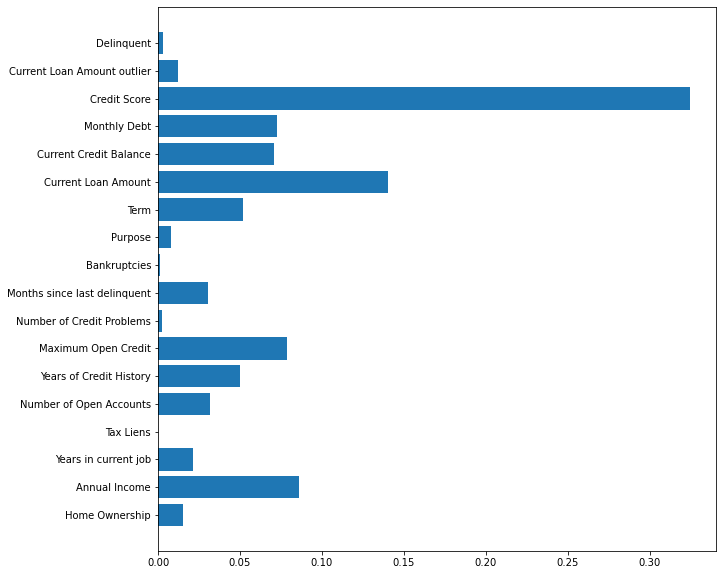

In [585]:
f_i = gbc.feature_importances_
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, f_i)
plt.show()

In [497]:
feature = pd.DataFrame([f_i], columns=X_train.columns)

In [498]:
feature

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Delinquent
0,0.01726,0.09976,0.02289,0.00004,0.03754,0.06021,0.09009,0.00479,0.03508,0.00036,0.00879,0.05783,0.08470,0.08749,0.08298,0.30698,0.00322


In [432]:
gb_model = GradientBoostingClassifier(criterion='mse', learning_rate =  0.1 , min_samples_leaf = 80, n_estimators = 150,  random_state = 42)

parameters = {
    'max_depth' : np.arange(4, 10),
    'max_features': np.arange(4, 10),
    
}
gs = GridSearchCV(
    estimator=gb_model,
    param_grid=parameters,
    scoring='f1',
    cv=5,
)
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 9, 'max_features': 10}